# LAB 4: Quantization


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

In [2]:
device = torch.device('cpu')

## Get the dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Model Declaration

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

## Training 

In [5]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader, verbose: bool=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None, verbose: bool=False) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            if verbose:
                print(images.size())
            images = images.to(device)
            labels = labels.to(device)


            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [6]:
train(net, trainloader)

Finished Training


In [7]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 53.13%


## Visualization of weights distribution

In [8]:
conv1_weights = net.conv1.weight.data.cpu().view(-1)
conv2_weights = net.conv2.weight.data.cpu().view(-1)
fc1_weights = net.fc1.weight.data.cpu().view(-1)
fc2_weights = net.fc2.weight.data.cpu().view(-1)
fc3_weights = net.fc3.weight.data.cpu().view(-1)

weights_names = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']
weights_values = [conv1_weights, conv2_weights, fc1_weights, fc2_weights, fc3_weights]

In [9]:
def compute_n_sigma_range(weights: torch.Tensor, n: int) -> Tuple[float, float]:
    mean = weights.mean()
    std = weights.std()
    return float(mean - n * std), float(mean + n * std)

In [10]:
weights_sigma_ranges = {}

for i in range(len(weights_names)):
    sigma_ranges = []
    for n in range(1, 4):
        sigma_ranges.append(compute_n_sigma_range(weights_values[i], n))

    weights_sigma_ranges[weights_names[i]] = sigma_ranges

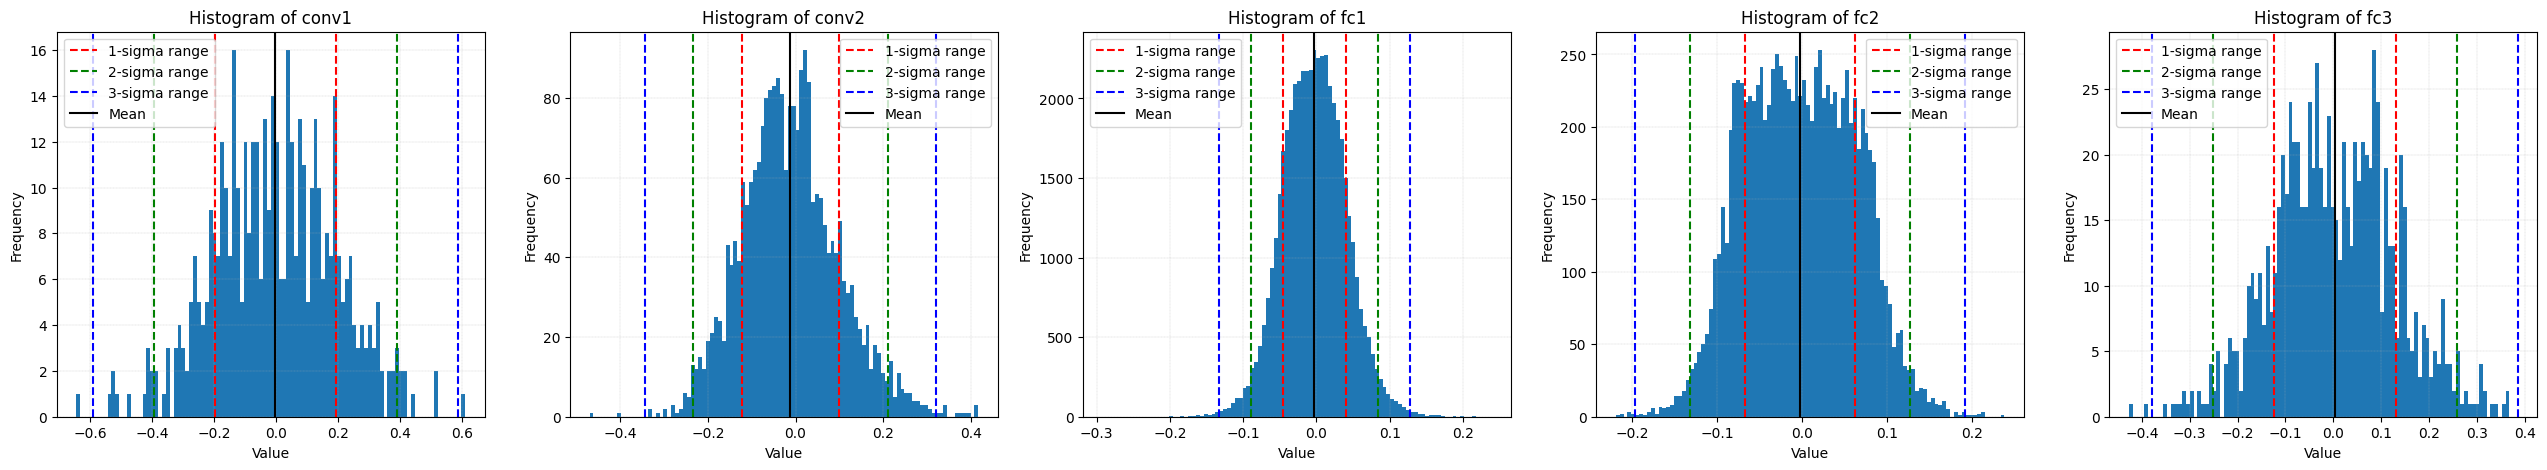

In [11]:
colors = ['r', 'g', 'b']
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(32, 5))

for i, name in enumerate(weights_names):
    for n in range(1, 4):
        ax[i].axvline(weights_sigma_ranges[name][n-1][0], color=colors[n-1], linestyle='--', label=f'{n}-sigma range')
        ax[i].axvline(weights_sigma_ranges[name][n-1][1], color=colors[n-1], linestyle='--')
    ax[i].axvline(weights_values[i].mean(), color='black', linestyle='-', label='Mean')
    ax[i].hist(weights_values[i].numpy(), bins=100)
    ax[i].set_title(f"Histogram of {name}")
    ax[i].set_xlabel('Value')
    ax[i].set_ylabel('Frequency')
    ax[i].grid(True, which='both', linestyle='--', linewidth=0.2)
    ax[i].legend()

In [43]:
# Range of values for each layer
print('Weights values ranges:')
for i, name in enumerate(weights_names):
    print(f'\t- {name} values range: {weights_values[i].min()} - {weights_values[i].max()}')

Weights values ranges:
	- conv1 values range: -0.6448280215263367 - 0.6096569299697876
	- conv2 values range: -0.469919890165329 - 0.4170401692390442
	- fc1 values range: -0.29182836413383484 - 0.2388831526041031
	- fc2 values range: -0.21937765181064606 - 0.23829403519630432
	- fc3 values range: -0.42714956402778625 - 0.368205189704895


In [12]:
# Percentage of weights outside n-sigma range
print('Percentage of weights outside n-sigma range')
for i in range(len(weights_names)):
    print(f'- {weights_names[i]}')
    for j in range(3):
        outside_range = len(weights_values[i][(weights_values[i] < weights_sigma_ranges[weights_names[i]][j][0]) | (weights_values[i] > weights_sigma_ranges[weights_names[i]][j][1])])
        percentage = outside_range / len(weights_values[i]) * 100
        print(f'\t- {j+1}-sigma range: {percentage:.3}%')

Percentage of weights outside n-sigma range
- conv1
	- 1-sigma range: 30.7%
	- 2-sigma range: 4.89%
	- 3-sigma range: 0.444%
- conv2
	- 1-sigma range: 30.1%
	- 2-sigma range: 4.83%
	- 3-sigma range: 0.583%
- fc1
	- 1-sigma range: 30.5%
	- 2-sigma range: 4.5%
	- 3-sigma range: 0.544%
- fc2
	- 1-sigma range: 36.8%
	- 2-sigma range: 3.03%
	- 3-sigma range: 0.179%
- fc3
	- 1-sigma range: 30.1%
	- 2-sigma range: 4.76%
	- 3-sigma range: 0.238%


## Post training quantization: Weights

In [13]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [14]:
def quantized_weights(weights: torch.Tensor, cutoff_value: float = 0.5, int_range: float = 127.0) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights
    cutoff_value (float): ±value around the mean to keep. Default is 0.5.
    int_range (float): The range of integers to map to. Default is 127.0.

    Returns:
    (Tensor, float): A tuple with the following elements:
                      * The weights in quantized form, where every value is an integer between -128 and 127.
                        The "dtype" will still be "float", but the values themselves should all be integers.
                      * The scaling factor that your weights were multiplied by.
                        This value does not need to be an 8-bit integer.
    '''

    if cutoff_value < 0:
        raise ValueError('cutoff_value must be non-negative')
    
    # If cutoff_value is 0, no clipping is done
    if cutoff_value != 0:
      mean = weights.mean()
      weights = torch.clamp(weights, mean - cutoff_value, mean + cutoff_value)

    scale = int_range / torch.max(torch.abs(weights))
    quantized_weights = weights * scale

    return torch.round(quantized_weights), scale


In [15]:
test_weights = fc1_weights.clone()
test_quantized_weights, test_scale = quantized_weights(test_weights, float(3*test_weights.std()))

print(f'Test weights: min = {test_weights.min()}, mean = {test_weights.mean()}, max = {test_weights.max()}')
print(f'Test quantized weights: {test_quantized_weights.min()} : {test_quantized_weights.max()}')

Test weights: min = -0.29182836413383484, mean = -0.002634757896885276, max = 0.2388831526041031
Test quantized weights: -127.0 : 122.0


In [16]:
def quantize_model(model: nn.Module, n_sigma:int):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data, float(n_sigma * layer.weight.data.cpu().view(-1).std()))
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

In [17]:
quantized_models = {}
for i in range(3):
    quantized_models[f"{i}-sigma"] = copy_model(net)

In [18]:
from tqdm import tqdm

scores = []
quantized_models = {}
for i in range(4):
    quantized_models[f"{i}-sigma"] = copy_model(net)

for i in tqdm(range(4), desc='Quantizing weights and testing accuracy'):
    n = quantized_models[f"{i}-sigma"]
    quantize_model(n, i)

    scores.append(test(n, testloader))

Quantizing weights and testing accuracy: 100%|██████████| 4/4 [00:53<00:00, 13.39s/it]


In [19]:
print(f'Accuracy of the network on the test images with no quantization: {scores[0]}%')
for i in range(2, -1, -1):
    print(f'Accuracy of the network on the test images with {i+1}-sigma quantization: {scores[i+1]}%')

Accuracy of the network on the test images with no quantization: 53.2%
Accuracy of the network on the test images with 3-sigma quantization: 52.83%
Accuracy of the network on the test images with 2-sigma quantization: 49.28%
Accuracy of the network on the test images with 1-sigma quantization: 36.86%


In [20]:
# Calcul de la taille en mémoire des poids du modèle net
def calculate_weights_memory(model: nn.Module) -> int:
    total_params = 0
    for param in model.parameters():
        total_params += param.element_size() * param.numel()
    # Convertir la taille en octets en mégaoctets
    total_memory = total_params / (1024 ** 2)  # 1 Mo = 1024^2 octets
    return total_memory

In [22]:
# Calcule la taille en mémoire du modèle de base et des modèles quantifiés
print(f'Taille en mémoire du modèle de base: {calculate_weights_memory(quantized_models["0-sigma"]):.4f} Mo')
for i in range(3, 0, -1):
    print(f'Taille en mémoire du modèle quantifié avec {i}-sigma: {calculate_weights_memory(quantized_models[f"{i}-sigma"]):.4f} Mo')

Taille en mémoire du modèle de base: 0.2356 Mo
Taille en mémoire du modèle quantifié avec 3-sigma: 0.2356 Mo
Taille en mémoire du modèle quantifié avec 2-sigma: 0.2356 Mo
Taille en mémoire du modèle quantifié avec 1-sigma: 0.2356 Mo


## Quantization activations

In [23]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [24]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

### Visualize activation distribution

In [28]:
input_activations = net_q3.input_activations
conv1_activations = net_q3.conv1.activations
conv2_activations = net_q3.conv2.activations
fc1_activations = net_q3.fc1.activations
fc2_activations = net_q3.fc2.activations
fc3_activations = net_q3.fc3.activations

activations_names = ['input', 'conv1', 'conv2', 'fc1', 'fc2', 'fc3']
activations_values = [input_activations, conv1_activations, conv2_activations, fc1_activations, fc2_activations, fc3_activations]

In [39]:
activations_sigma_ranges = {}

for i in range(len(activations_names)):
    sigma_ranges = []
    for n in range(1, 4):
        sigma_ranges.append(compute_n_sigma_range(torch.tensor(activations_values[i]), n))

    activations_sigma_ranges[activations_names[i]] = sigma_ranges

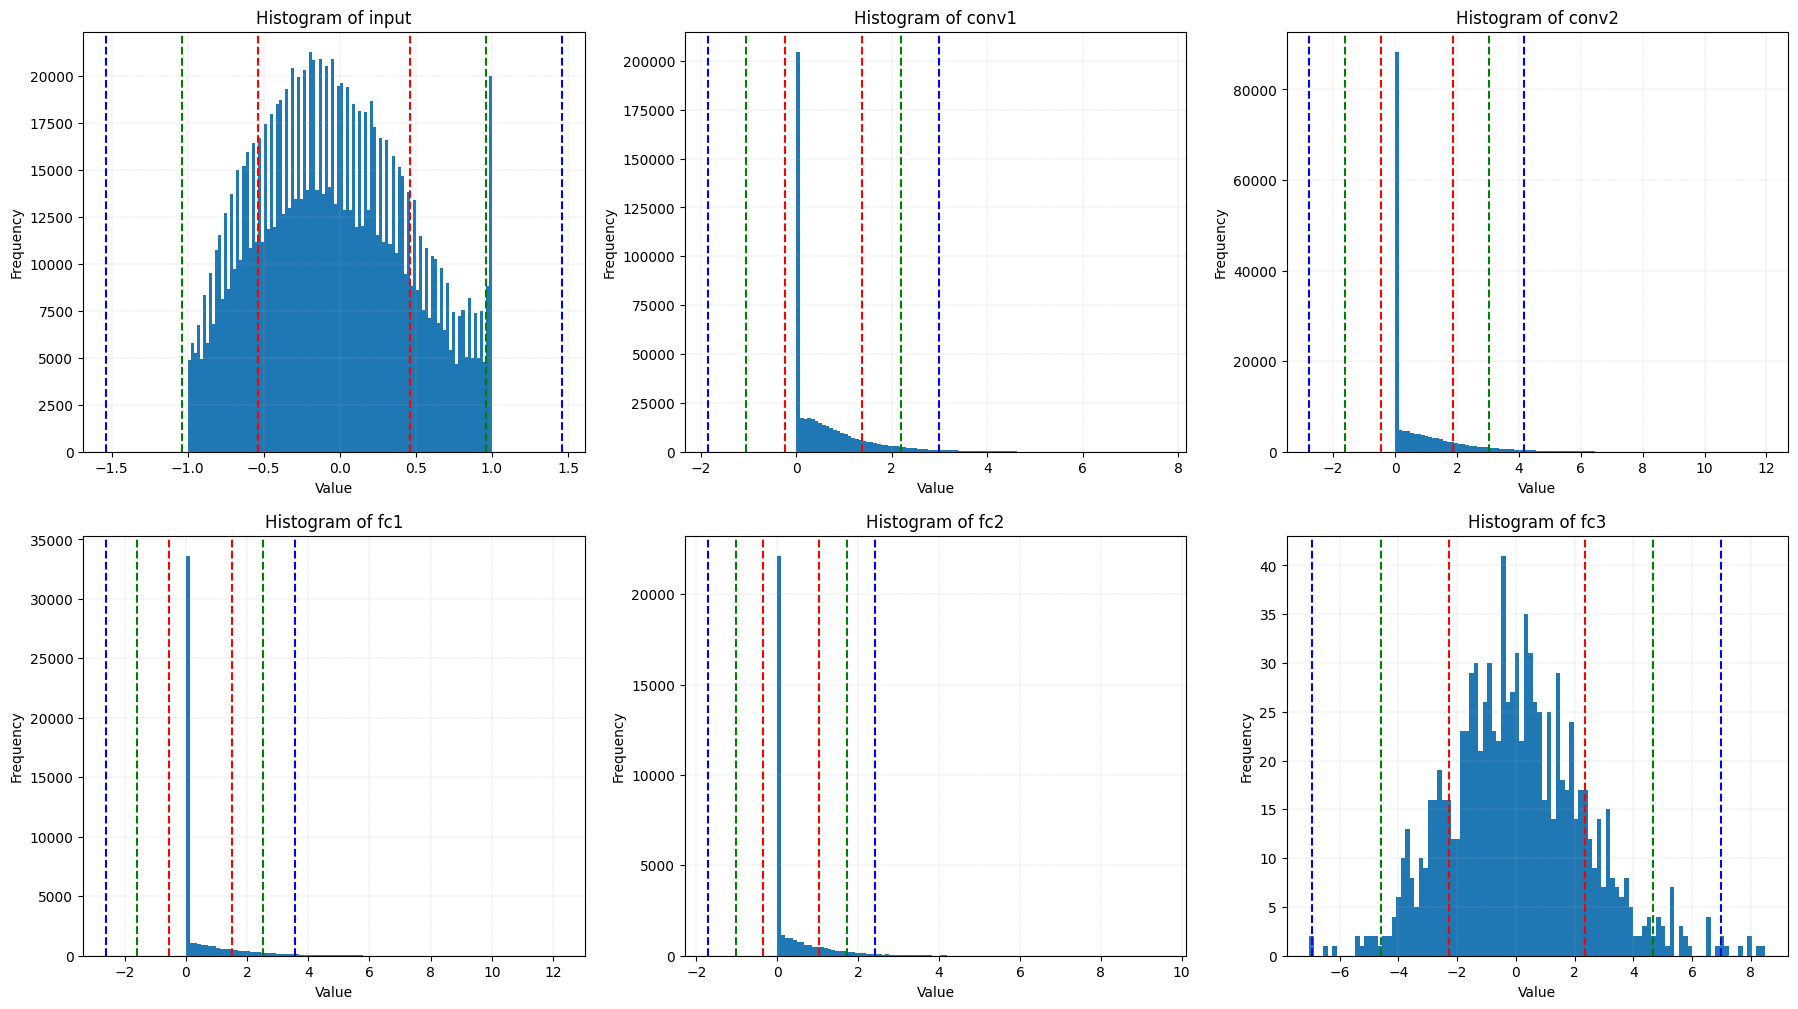

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(22, 12))

for i, name in enumerate(activations_names):
    for n in range(1, 4):
        ax[i//3, i%3].axvline(activations_sigma_ranges[name][n-1][0], color=colors[n-1], linestyle='--', label=f'{n}-sigma range')
        ax[i//3, i%3].axvline(activations_sigma_ranges[name][n-1][1], color=colors[n-1], linestyle='--')
    ax[i//3, i%3].hist(activations_values[i], bins=100)
    ax[i//3, i%3].set_title(f"Histogram of {name}")
    ax[i//3, i%3].set_xlabel('Value')
    ax[i//3, i%3].set_ylabel('Frequency')
    ax[i//3, i%3].grid(True, which='both', linestyle='--', linewidth=0.2)

In [44]:
# Range of values for each layer
print('Activations values ranges:')
for i, name in enumerate(weights_names):
    print(f'\t- {name} values range: {activations_values[i].min()} - {activations_values[i].max()}')

Activations values ranges:
	- conv1 values range: -1.0 - 1.0
	- conv2 values range: 0.0 - 7.69439697265625
	- fc1 values range: 0.0 - 11.964548110961914
	- fc2 values range: 0.0 - 12.286710739135742
	- fc3 values range: 0.0 - 9.551739692687988


### Quantize activations

In [24]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(initial_input: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        initial_input (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        scale_factor = 127. / torch.max(torch.abs(initial_input))

        return scale_factor

    @staticmethod
    def quantize_activations(activations: np.ndarray, s_w: float, s_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        s_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        s_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the next layer.
               This value does not need to be an 8-bit integer.
        '''

        # Scale to apply to the current layer's activations
        scale = 127. / torch.max(torch.abs(activations))
        
        # Product of the scales applied in the preceding layers
        for w_s, o_s in ns:
            scale *= w_s * o_s
       
        # Multiplying the total scale by the scale of the input
        return scale * s_initial_input

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale
        # You don't need to quantize Relu outputs 

        # ADD YOUR CODE HERE (Replace the ...)
        # ...
        x = self.pool(F.relu(x))
        x = torch.clamp(x, min=-128, max=127)
        # ...
        x = self.pool(F.relu(x))
        x = torch.clamp(x, min=-128, max=127)
        # ...
        x = x.view(-1, 16 * 5 * 5)
        # ...
        x = F.relu(x)
        # ...
        x = F.relu(x)
        # ...

        return x

In [25]:
# Merge the information from net_q2 and net_q3 together

net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

NameError: name 'net_q2' is not defined

In [ ]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))